### Stock model predictor


This notebook demonstrate a novelty approach of using deep neural network for stock price prediction model. We compare the result to Gaussian process regressor with Metern and RBF Kernals 

Import required libraries. Including Numpy, pandas, Matplotlib, Keras for
data manipulation, building Neural network models

In [33]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [34]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model

In [35]:
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Define a function to read the csv file which contains the stock data,
Read sample data

In [36]:
np.random.seed(7)
def readStockData(file, path='./data/'):

    data = pd.read_csv(path+file)
    return data

dataset = readStockData('JPM.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,27/11/2017,98.309998,99.129997,97.930000,97.930000,95.736626,13076200
1,28/11/2017,98.209999,101.699997,97.970001,101.360001,99.089813,16773000
2,29/11/2017,102.410004,104.220001,101.959999,103.730003,101.406731,21105500
3,30/11/2017,104.739998,106.660004,104.040001,104.519997,102.179024,23945900
4,01/12/2017,104.900002,105.320000,102.199997,104.790001,102.442986,19683500


Data cleaning method to remove unwanted data entry, In this case we look at close price in particular

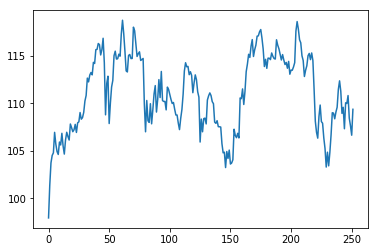

In [37]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Close'] = pd.to_numeric(dataset['Close'], downcast='float')
dataset.set_index('Date',inplace=True)

close = dataset['Close']
close = close.values.reshape(len(close), 1)
plt.plot(close)
plt.show()

#### The below function creates sets of time series data from a continuous data

In [38]:
series=7
def create_ts(ds, series=7):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)


### LSTM method for stock prediction

The below code is organised as follow
- Scaling data as preprocessing
- Covert stock data to time series data
- Define two layers models for LSTM model and train the model
- Calculate Mean square loss error.

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
close  = scaler.fit_transform(close)
TrainData , TestData = close[0:220], close[220:]

In [40]:
trainX, trainY = create_ts(TrainData, series=7)
testX, testY = create_ts(TestData, series=7)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Model definition: Two layers with cell states 16 and 30, Summarised by a fully-connected layer

In [41]:
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(series, 1)))
model.add(Dropout(0.2))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))


model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=30)

Epoch 1/150
212/212 [==============================] - 2s 11ms/step - loss: 0.3743
Epoch 2/150
212/212 [==============================] - 0s 766us/step - loss: 0.1915
Epoch 3/150
212/212 [==============================] - 0s 807us/step - loss: 0.0472
Epoch 4/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 5/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 6/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 7/150
212/212 [==============================] - 0s 809us/step - loss: 0.0147
Epoch 8/150
212/212 [==============================] - 0s 721us/step - loss: 0.0141
Epoch 9/150
212/212 [==============================] - 0s 930us/step - loss: 0.0134
Epoch 10/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 11/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 12/150
212/212 [==============================] - 0s 1ms/step - loss: 0.0142
Ep

Epoch 98/150
212/212 [==============================] - 0s 709us/step - loss: 0.0091
Epoch 99/150
212/212 [==============================] - 0s 627us/step - loss: 0.0093
Epoch 100/150
212/212 [==============================] - 0s 646us/step - loss: 0.0094
Epoch 101/150
212/212 [==============================] - 0s 634us/step - loss: 0.0100
Epoch 102/150
212/212 [==============================] - 0s 641us/step - loss: 0.0089
Epoch 103/150
212/212 [==============================] - 0s 660us/step - loss: 0.0089
Epoch 104/150
212/212 [==============================] - 0s 650us/step - loss: 0.0089
Epoch 105/150
212/212 [==============================] - 0s 665us/step - loss: 0.0083
Epoch 106/150
212/212 [==============================] - 0s 660us/step - loss: 0.0086
Epoch 107/150
212/212 [==============================] - 0s 636us/step - loss: 0.0084
Epoch 108/150
212/212 [==============================] - 0s 660us/step - loss: 0.0090
Epoch 109/150
212/212 [==============================] -

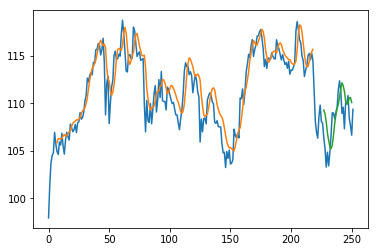

In [42]:
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)

trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])


train_plot = np.empty_like(close)
train_plot[:,:] = np.nan
train_plot[7:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(close)-1, :] = testPredictions

plt.plot(scaler.inverse_transform(close))
plt.plot(train_plot)
plt.plot(test_plot)

plt.show()

In [43]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 1.74446799634281
Test score: %.2f rmse 2.402572655894238


### Gaussian process regressor


The below code is organised as follow
- Scaling data as preprocessing
- Covert stock data to time series data
- Define GPR model with Matern and RBF Kernal
- Calculate Mean square loss error.

In [44]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern

In [45]:
trainX, trainY = create_ts(TrainData, series=7)
testX, testY = create_ts(TestData, series=7)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1]))


print (trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

shape_train = trainX.shape[0]
shape_test = testX.shape[0]

(212, 7) (212,)
(24, 7) (24,)


In [46]:
kernel = Matern(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpr.fit(trainX, trainY)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5) * RBF(length_scale=10),
             n_restarts_optimizer=9, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

(212, 1)
(24, 1)


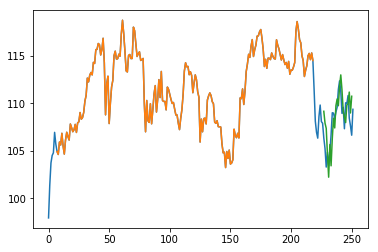

In [47]:
trainPredictions = gpr.predict(trainX)
testPredictions = gpr.predict(testX)


trainPredictions = np.reshape(trainPredictions, [shape_train,1])
testPredictions = np.reshape(testPredictions, [shape_test,1])

print(trainPredictions.shape)
print(testPredictions.shape)


trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)

trainY = np.reshape(trainY, [shape_train,1])
testY = np.reshape(testY, [shape_test,1])
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

train_plot = np.empty_like(close)
train_plot[:,:] = np.nan
train_plot[7:len(trainPredictions)+series, :] = trainPredictions


test_plot = np.empty_like(close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(close)-1, :] = testPredictions


#future_plot = np.empty_like(close)
#test_plot[:,:] = np.nan

plt.plot(scaler.inverse_transform(close))
plt.plot(train_plot)
plt.plot(test_plot)

plt.show()


In [48]:
#print(testY.shape, testPredictions.shape)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 3.352558465508082e-06
Test score: %.2f rmse 2.8105365915334204
